## This is a quick tutorial on how to use BayLIME to explain an image.

by XZ 05/10/2020

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image
import csv
from lime import calculate_posteriors
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.2.4-tf


Same as the original LIME tutorial, we are reusing the pretrained DNN InceptionV3.

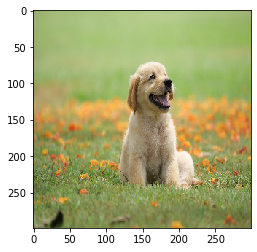

('n02099601', 'golden_retriever', 0.7591777)
('n02099712', 'Labrador_retriever', 0.13248245)
('n02102318', 'cocker_spaniel', 0.015283059)
('n02101556', 'clumber', 0.014689475)
('n02104029', 'kuvasz', 0.0038136626)


In [2]:
#Same as the original LIME tutorial,
#here we create a standard InceptionV3 pretrained model 
#and use it on images by first preprocessing them with the preprocessing tools
inet_model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


images = transform_img_fn([os.path.join('data','5.jpg')])
# I'm dividing by 2 and adding 0.5 because of
# how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
plt.show()
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

#### Now we create an instance of LIME explainer with an arg _feature_selection='none'_ meaning we will consider all features of the image in our later explanation. You may also specify other args like kernel_width etc. For a complete list of args, cf. the comments in the sources code when defining the class.

In [3]:
explainer = lime_image.LimeImageExplainer(feature_selection='none')#kernel_width=0.1

#### First, let us explain the image _image[0]_ with the original LIME -- i.e. with option _model_regressor='non_Bay'_ .

Meanings behind other args, again, can be found in comments of the source codes when defining the function. E.g., _number_samples=200_ represents the number of perturbed samples used for the training of the local surrogate model.

the number of features: 63


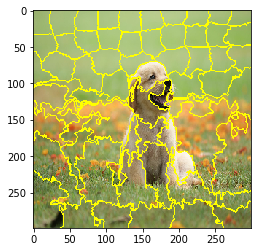


using non_Bay option for model regressor
using non_Bay option for model regressor
using non_Bay option for model regressor


In [4]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=3, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='non_Bay')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

Now we have done the explanations for the top 3 labels. We have different ways to present the explanation results -- to show a few regarding the top label as the following:
1. Showing top 10 features and hide the rest. Also the 10 features could have both positive and negative contribution to the prediction.
2. Only showing the top 5 positive features without hiding the rest.
3. Or we can simply present the 'importance' of each feature as a list.

Note, the mean and variance information for the top 10 features are internal assertions that can be switched off (assuming they are repetitive in some cases). In this case, since we are using non-bay option, there is no mean/variance actually, so you see a 0 variance and mean really represents the fitted coefficient by the Linear Regressor.

For feature of segment 36
The mean of the (posterior) coefficient 0.13276160624934535
The variance of the (posterior) coefficient 0.0
For feature of segment 34
The mean of the (posterior) coefficient 0.09035533973567555
The variance of the (posterior) coefficient 0.0
For feature of segment 29
The mean of the (posterior) coefficient 0.07949350259131886
The variance of the (posterior) coefficient 0.0
For feature of segment 47
The mean of the (posterior) coefficient 0.07147935230560712
The variance of the (posterior) coefficient 0.0
For feature of segment 48
The mean of the (posterior) coefficient 0.049786039048141946
The variance of the (posterior) coefficient 0.0
For feature of segment 62
The mean of the (posterior) coefficient -0.04572731976102786
The variance of the (posterior) coefficient 0.0
For feature of segment 28
The mean of the (posterior) coefficient 0.04290778021295497
The variance of the (posterior) coefficient 0.0
For feature of segment 32
The mean of the (posterior) coeffi

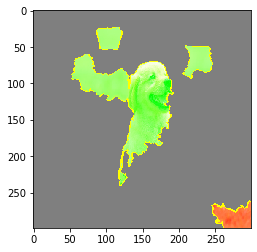

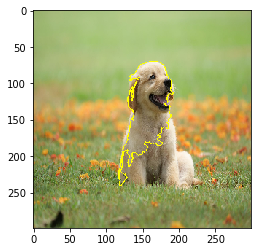

[('36', 0.13276160624934535), ('34', 0.09035533973567555), ('29', 0.07949350259131886), ('47', 0.07147935230560712), ('48', 0.049786039048141946), ('62', -0.04572731976102786), ('28', 0.04290778021295497), ('32', 0.04120791913374012), ('21', 0.03894253385992289), ('14', 0.03842868942403947), ('6', -0.03630990511323955), ('33', 0.03621413870838), ('27', 0.03515734414624788), ('10', 0.033006108756997034), ('7', -0.031605378146664684), ('57', 0.031235459378849972), ('35', 0.03094661008222366), ('46', 0.030407811761403024), ('55', -0.03024407474171997), ('15', 0.029259979794475817), ('53', 0.0276358879518533), ('43', 0.026993522195854318), ('39', 0.025752770478186714), ('52', -0.024902965426247065), ('60', -0.02472005311007471), ('51', 0.021405395640746644), ('4', -0.02040546017011863), ('50', 0.016615312329441707), ('42', 0.015578627685951257), ('11', 0.015562471343520689), ('49', -0.01491796052352651), ('31', 0.014020831972392154), ('61', -0.013732811787920123), ('58', 0.0130580075080933

In [5]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the image _image[0]_ with BayLIME but without any prior information -- i.e. with option _model_regressor='Bay_non_info_prior'_ .

Essentially we use a zero mean vector as prior knowledge with fitted precision parameters.

Note, you will see 1 set of fitted alpha and lambda parameters (cf. the BayLIME paper for the meanings of these two parameters..) that corresponds to the explanations to the top 1 label.

the number of features: 63


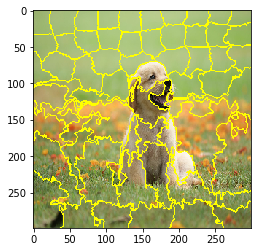


using Bay_non_info_prior option for model regressor
Convergence after  8  iterations
the alpha is 129.21390007723429
the lambda is 1037.8258389277487
the regulation term lambda/alpha is 8.031843619822752


In [6]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='Bay_non_info_prior')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

##### It is worth to note that the fitted alpha and lambda parameters are recorded in a CSV file './posterior_configure.csv'

For feature of segment 36
The mean of the (posterior) coefficient 0.1130756954014647
The variance of the (posterior) coefficient 0.0002774824276715561
For feature of segment 34
The mean of the (posterior) coefficient 0.08689637813577868
The variance of the (posterior) coefficient 0.0002645598938618879
For feature of segment 29
The mean of the (posterior) coefficient 0.06969985874599507
The variance of the (posterior) coefficient 0.00026779734458811337
For feature of segment 50
The mean of the (posterior) coefficient 0.04367803676795074
The variance of the (posterior) coefficient 0.0002839849872696065
For feature of segment 46
The mean of the (posterior) coefficient 0.031751034715033155
The variance of the (posterior) coefficient 0.00027169680867689675


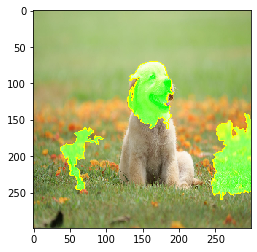

[('36', 0.1130756954014647), ('34', 0.08689637813577868), ('29', 0.06969985874599507), ('50', 0.04367803676795074), ('46', 0.031751034715033155), ('52', 0.0317076733379498), ('33', 0.031119121339311343), ('32', 0.03011254903687039), ('0', 0.029972857634256868), ('1', 0.02953807851403732), ('62', 0.028386553210894956), ('6', 0.027822430610175496), ('39', 0.027498275270095695), ('53', 0.02517372417109856), ('8', 0.024314887141911327), ('51', -0.023793994947055794), ('18', 0.02178953274176474), ('48', 0.021265661828005957), ('4', -0.020184935679068042), ('47', 0.01960002082229699), ('9', 0.019238646125675316), ('37', 0.018865245411600673), ('26', 0.01863471516880727), ('2', 0.018472528739397913), ('22', -0.016315239111994922), ('17', 0.015487652526452067), ('35', 0.015368266526458067), ('31', 0.014551064214420404), ('40', -0.013456339679646923), ('44', -0.013027884119892922), ('24', 0.0122256458493025), ('21', 0.011782085233930126), ('27', 0.011676658811567316), ('16', 0.01153771843221119

In [7]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the top 1 label of the image _image[0]_ with BayLIME and with full prior knowledge -- i.e. with option _model_regressor='Bay_info_prior'_ .

You will see, in this case, we read the alpha and lambda parameters from the CSV file  './configure.csv'. Moreover, after the explanation, we will again write the parameters into the  './posterior_configure.csv' file.

the number of features: 63


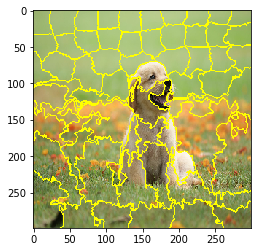


using Bay_info_prior option for model regressor
the alpha is 1.0
the lambda is 20.0
the regulation term lambda/alpha is 20.0


In [8]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=1, batch_size=10,
                                         num_samples=200,model_regressor='Bay_info_prior')

The following code simply reads the values of the alpha and lambda parameters from the CSV file into two variables.

In [9]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

Now in the current explanation, only the data has spoken for themselves (i.e. the second term in the eq. (15) in the BayLIME paper), while the priors knowledge hasn't been combined in (the first term in the eq. (15) in the BayLIMe paper). Now let us combine the prior knowledge (a prior mean vector for all features) that stored in the file '.\data\prior_knowledge_5_jpg.csv'

In [10]:
explanation=calculate_posteriors.get_posterior(explanation,'.\data\prior_knowledge_5_jpg.csv',
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])


For feature of segment 34
The mean of the (posterior) coefficient 0.15373946729177054
The variance of the (posterior) coefficient 0.023734732175771395
For feature of segment 36
The mean of the (posterior) coefficient 0.15175257991262373
The variance of the (posterior) coefficient 0.024210431654006177
For feature of segment 29
The mean of the (posterior) coefficient 0.10533821764606081
The variance of the (posterior) coefficient 0.024174273252639166
For feature of segment 47
The mean of the (posterior) coefficient 0.036979093762165634
The variance of the (posterior) coefficient 0.024187015647250457
For feature of segment 32
The mean of the (posterior) coefficient 0.03549114631295525
The variance of the (posterior) coefficient 0.02417097672276327


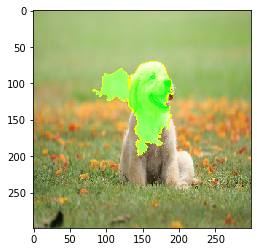

[('34', 0.15373946729177054), ('36', 0.15175257991262373), ('29', 0.10533821764606081), ('47', 0.036979093762165634), ('32', 0.03549114631295525), ('48', 0.03532288570300861), ('27', 0.02695004236602263), ('19', 0.025128055157615653), ('0', 0.02422507575529513), ('50', 0.023984522160786136), ('33', 0.023904003135524474), ('15', 0.022074641877175585), ('10', 0.02133657179272791), ('12', 0.020771429620393394), ('3', 0.020540458493023633), ('9', 0.01940380677240283), ('23', 0.01929142974951708), ('35', 0.019169067422927115), ('53', 0.018044233841662784), ('26', 0.017801741755781884), ('55', 0.017438640991349712), ('60', 0.015634721969299503), ('21', 0.014331082176870154), ('28', 0.013586793658602212), ('7', 0.013409666936422537), ('45', 0.013005690476651108), ('30', 0.01283711392110955), ('24', -0.012052543438882056), ('25', 0.011451113451891703), ('5', 0.011188101073412527), ('58', -0.01111579508229122), ('2', 0.010733885847932372), ('39', 0.01070366884119514), ('18', -0.0100077570048660

In [11]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Finally, we explain the top 1 label of the image _image[0]_ with BayLIME and with *partial* prior knowledge -- i.e. with option _model_regressor='BayesianRidge_inf_prior_fit_alpha'_ .

You will see, in this case, we fit the alpha from data and read the lambda parameter from the CSV file  './configure.csv'. Then, after the explanation, we will again write both the alpha and lambda parameters into the  './posterior_configure.csv' file.

the number of features: 63


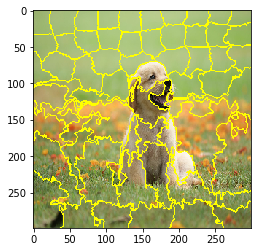


using Bay_info_prior_fixed_lambda_fit_alpha option for model regressor
Convergence after  3  iterations
the alpha is 110.55570231108001
the lambda is 20.0
the regulation term lambda/alpha is 0.18090428247404455


In [12]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='BayesianRidge_inf_prior_fit_alpha')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

The rest of the steps are the same as before (i.e. the case using the full prior knowledge...)

In [13]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

In [14]:
explanation=calculate_posteriors.get_posterior(explanation,'.\data\prior_knowledge_5_jpg.csv',
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])

For feature of segment 34
The mean of the (posterior) coefficient 0.1411575319474857
The variance of the (posterior) coefficient 0.000608595869097665
For feature of segment 36
The mean of the (posterior) coefficient 0.13697670756627373
The variance of the (posterior) coefficient 0.0004662594860395589
For feature of segment 29
The mean of the (posterior) coefficient 0.11054047721989887
The variance of the (posterior) coefficient 0.0006084927456603274
For feature of segment 47
The mean of the (posterior) coefficient 0.09884720736974117
The variance of the (posterior) coefficient 0.0005071611603169153
For feature of segment 61
The mean of the (posterior) coefficient 0.07422073038387517
The variance of the (posterior) coefficient 0.0005157385272385424


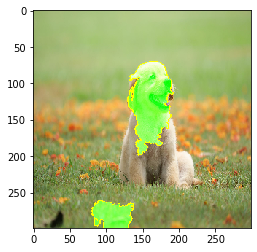

[('34', 0.1411575319474857), ('36', 0.13697670756627373), ('29', 0.11054047721989887), ('47', 0.09884720736974117), ('61', 0.07422073038387517), ('33', 0.06455280251482087), ('7', 0.05707032877052318), ('32', 0.05334232346870351), ('50', 0.05297354137233889), ('18', -0.05256403261433226), ('1', 0.04927879997949782), ('24', 0.04892986259150577), ('9', -0.04869343654249857), ('12', -0.045941860310177184), ('21', 0.04584758497485788), ('23', 0.043591156438861904), ('27', 0.042287829446229545), ('55', -0.04197168760423707), ('54', -0.041224006735822), ('52', -0.03227864891647909), ('62', 0.03139562034779946), ('48', 0.029282775073824062), ('42', -0.02797351458979925), ('59', 0.02711030062341742), ('15', -0.02648543977230136), ('11', 0.024356586803875084), ('28', -0.023401386594617928), ('16', 0.02314650737813526), ('53', 0.022623029404914192), ('0', 0.021539249778265324), ('22', -0.02120513701180734), ('4', 0.02017380651839549), ('25', 0.018984514365802747), ('57', 0.017906588809409475), (

In [15]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))